Attention in RNNs ([blog](http://www.wildml.com/2016/01/attention-and-memory-in-deep-learning-and-nlp/)):
- when translating from english to german, the first word in english is usually translated directly to the first word in german
- but for japanese, the order is different
- instead of manually chosing which order to present the words in, we allow the network to do it automatically
- the output of each word depends on a linear combination of all the input states (not just the last one, which is an aggregation of the previous ones)
- more fitting name would be "memory"

Conclusion: fit for seq2seq, not classification

![pic](http://www.wildml.com/wp-content/uploads/2015/12/Screen-Shot-2015-12-30-at-1.23.48-PM-768x825.png)

Hierarchical Attention Network ([blog](https://medium.com/analytics-vidhya/hierarchical-attention-networks-d220318cf87e)):
 - two levels: sentence attention and word attention
 - derive sentence meaning from words and then derive document meaning from sentences
 - in our case:
   - document = all of a user's tweets
   - sentence = one tweet
 
![pic](https://cdn-images-1.medium.com/max/2000/1*28XVtq2lOjOmZhcSgu1NmQ.png)

---

[inspiration](https://github.com/lzfelix/keras_attention)

## data

In [1]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
datasets = [
    '/Users/stefan/Downloads/processed_tweets_chunks/top100users_processed.csv',
#     '/Users/stefan/Downloads/processed_tweets_chunks/15M_5001_10000.csv',
#     '/Users/stefan/Downloads/processed_tweets_chunks/15M_10000_99999999.csv'
]

In [3]:
%%time 
tweets = pd.concat(
    pd.read_csv(path)
    for path in datasets
).dropna(subset=['text_token'])

CPU times: user 1.54 s, sys: 164 ms, total: 1.71 s
Wall time: 1.71 s


## preprocess

idea: try adding start and end tokens for each tweet

In [4]:
SEQ_LEN = 12
EMBEDDING_SIZE = 50

In [63]:
import numpy as np
import gensim.downloader
from sklearn.preprocessing import StandardScaler

In [6]:
%time glove = gensim.downloader.load(f'glove-twitter-{EMBEDDING_SIZE}')  # also downloads 199MB model

CPU times: user 52.9 s, sys: 445 ms, total: 53.4 s
Wall time: 53.7 s


In [7]:
%time tweets.text_token = tweets.text_token.map(eval)

CPU times: user 3.89 s, sys: 23.7 ms, total: 3.91 s
Wall time: 3.91 s


In [40]:
dictionary = {w for tokens in tweets.text_token for w in tokens}  # from the dataset
dictionary = [w for w in all_words if w in glove]  # from the embeddings
dictionary = ['<PAD>'] + dictionary

dictionary_set = set(dictionary)

In [27]:
VOCAB_SIZE = len(dictionary)  # plus padding
VOCAB_SIZE

47248

In [28]:
index2word = {i: w for i, w in enumerate(dictionary)}
word2index = {w: i for i, w in index2word.items()}

In [59]:
index_seqs = [
    [word2index[w] for w in words if w in dictionary_set]
    for words in tweets.text_token
]

In [107]:
min_len = 4
long_enough = [len(seq) >= min_len for seq in index_seqs]
tweets = tweets[long_enough]  # drop tweets that are not long enough
tweets.index = np.arange(len(tweets))
len(tweets)

166298

In [61]:
index_seqs = [seq for seq, valid in zip(index_seqs, long_enough) if valid]

In [62]:
X = pad_sequences(index_seqs, SEQ_LEN, padding='post', truncating='post', value=0)

In [64]:
engagement_score = tweets.engagment / tweets.n_user_followers * 100 + 1
y = np.log(engagement_score.values)

In [65]:
y = StandardScaler().fit_transform(y.reshape(-1, 1)).reshape(-1)

In [66]:
X.shape

(166298, 12)

In [67]:
y.shape

(166298,)

## model

In [153]:
RNN_SIZE = 32

In [69]:
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from attention.layers import AttentionLayer

In [70]:
embedding_weights = np.array([np.zeros(glove.vector_size)] +  # padding
                             [glove.get_vector(w) for w in all_words])

In [165]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=SEQ_LEN, mask_zero=True, 
              weights=[embedding_weights], trainable=False),
    LSTM(RNN_SIZE, return_sequences=True, recurrent_dropout=.4),
    AttentionLayer(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.summary()
model.compile('adam', 'mae')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 12, 50)            2362400   
_________________________________________________________________
lstm_18 (LSTM)               (None, 12, 32)            10624     
_________________________________________________________________
attention_layer_18 (Attentio (None, 32)                1088      
_________________________________________________________________
dense_27 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17        
Total params: 2,374,657
Trainable params: 12,257
Non-trainable params: 2,362,400
_________________________________________________________________


In [166]:
model.fit(X, y, batch_size=256, epochs=20)

Epoch 1/20
166298/166298 [==============================] - 12s 71us/step - loss: 0.3694
Epoch 2/20
166298/166298 [==============================] - 9s 55us/step - loss: 0.3648
Epoch 3/20
166298/166298 [==============================] - 9s 56us/step - loss: 0.3625
Epoch 4/20
166298/166298 [==============================] - 10s 58us/step - loss: 0.3607
Epoch 5/20
166298/166298 [==============================] - 10s 58us/step - loss: 0.3593
Epoch 6/20
166298/166298 [==============================] - 10s 59us/step - loss: 0.3576
Epoch 7/20
166298/166298 [==============================] - 10s 61us/step - loss: 0.3556
Epoch 8/20
166298/166298 [==============================] - 11s 64us/step - loss: 0.3536
Epoch 9/20
166298/166298 [==============================] - 11s 64us/step - loss: 0.3510
Epoch 10/20
166298/166298 [==============================] - 10s 62us/step - loss: 0.3491
Epoch 11/20
166298/166298 [==============================] - 10s 62us/step - loss: 0.3467
Epoch 12/20
166298/16

In [168]:
model.save('attention-model.h5')

In [167]:
# gets weights from the main model, same layers except for the final one, and without dropout
viz_model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=SEQ_LEN, mask_zero=True, 
              weights=model.layers[0].get_weights()),
    
    LSTM(RNN_SIZE, return_sequences=True,
                  weights=model.layers[1].get_weights()),
 
    AttentionLayer(return_attention=True,
                   weights=model.layers[2].get_weights())
])

## viz

In [169]:
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
%matplotlib inline

In [170]:
white = 'white'  # to avoid triple quote level because jupyter does not handle it well
black = 'black'

In [180]:
def consult_models(index):
    sample = X[index]
    words = [index2word[word] for word in sample]


    # consult models
    sample_ = sample[np.newaxis, :]
    pred = model.predict(sample_).item()
    attention = viz_model.predict(sample_).reshape(-1)
    
    return pred, y[index], words, attention

[USC colors](https://identity.usc.edu/print/colors/)

In [185]:
def highlight_words(words, attention):
    alphas = attention.copy()  # rescale
    alphas -= min(alphas)
    alphas /= max(alphas)
    alphas **= 1.5
    parts = [
        f'''<span style="background: rgba(255, 204, 0, {alpha});
                         color: {white if alpha > 1 else black};
                         padding: 2px 4px;
                         font-weight=600"
                       >
                {word}
            </span>'''
        for word, alpha in zip(words, alphas)
    ]
    text = ' '.join(parts)
    display(Markdown(' '.join(parts)))

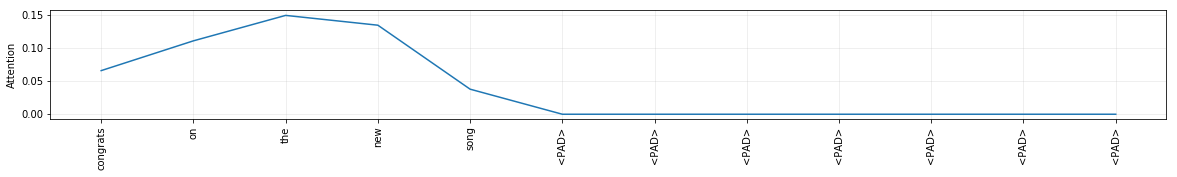

In [97]:
# plot
plt.figure(figsize=(20, 2))
plt.plot(range(len(attention)), attention)
plt.xticks(range(len(attention)), words, rotation=90)

plt.grid(alpha=.25)
plt.ylabel('Attention')
plt.show()

---

In [186]:
for index in tweets[(tweets.swear_count > 0) & (tweets.text_len > 120)].sort_values(by='engagment').head(100).index:
    pred, actual, words, attention = consult_models(index)
    highlight_words(words, attention)
    print('\n')

<span style="background: rgba(255, 204, 0, 0.010233762674033642);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                because
            </span> <span style="background: rgba(255, 204, 0, 0.5037718415260315);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.04507489502429962);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                as
            </span> <span style="background: rgba(255, 204, 0, 0.0014841367956250906);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.001635447726584971);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                huge
            </span> <span style="background: rgba(255, 204, 0, 0.004841797053813934);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.13498340547084808);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                modifying
            </span> <span style="background: rgba(255, 204, 0, 0.17481359839439392);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                right
            </span> <span style="background: rgba(255, 204, 0, 0.0684228241443634);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                now
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                lol
            </span> <span style="background: rgba(255, 204, 0, 0.010794202797114849);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span>

<span style="background: rgba(255, 204, 0, 0.1538134217262268);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                all
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.10745598375797272);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                can
            </span> <span style="background: rgba(255, 204, 0, 0.2602510452270508);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tell
            </span> <span style="background: rgba(255, 204, 0, 0.04871116206049919);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.005309258121997118);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                for
            </span> <span style="background: rgba(255, 204, 0, 0.008948792703449726);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sure
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.5611035823822021);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.013716109097003937);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                can
            </span> <span style="background: rgba(255, 204, 0, 0.0011267627123743296);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                not
            </span> <span style="background: rgba(255, 204, 0, 0.5481072664260864);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                stand
            </span>

<span style="background: rgba(255, 204, 0, 0.007327410392463207);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span> <span style="background: rgba(255, 204, 0, 0.15111936628818512);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                shitty
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                restaurant
            </span> <span style="background: rgba(255, 204, 0, 0.06291432678699493);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.21618999540805817);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                orlando
            </span> <span style="background: rgba(255, 204, 0, 0.013299502432346344);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.012218243442475796);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wa
            </span> <span style="background: rgba(255, 204, 0, 0.0023118718527257442);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span> <span style="background: rgba(255, 204, 0, 0.418190062046051);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                music
            </span> <span style="background: rgba(255, 204, 0, 0.1788046807050705);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                competition
            </span> <span style="background: rgba(255, 204, 0, 0.8919055461883545);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span>

<span style="background: rgba(255, 204, 0, 0.00928558874875307);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 4.021131826448254e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                will
            </span> <span style="background: rgba(255, 204, 0, 0.003412996418774128);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span> <span style="background: rgba(255, 204, 0, 0.0021335002966225147);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                there
            </span> <span style="background: rgba(255, 204, 0, 0.00609088409692049);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.020012063905596733);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                so
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fucking
            </span> <span style="background: rgba(255, 204, 0, 0.39247366786003113);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hard
            </span> <span style="background: rgba(255, 204, 0, 0.0006951430696062744);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.06006347015500069);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                frustrating
            </span> <span style="background: rgba(255, 204, 0, 0.008021233603358269);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                at
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                first
            </span>

<span style="background: rgba(255, 204, 0, 0.18346472084522247);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.036660194396972656);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                do
            </span> <span style="background: rgba(255, 204, 0, 0.001809476176276803);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                not
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fucking
            </span> <span style="background: rgba(255, 204, 0, 0.13421685993671417);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                know
            </span> <span style="background: rgba(255, 204, 0, 6.405365274986252e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.047225456684827805);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                mathematical
            </span> <span style="background: rgba(255, 204, 0, 0.0045740632340312);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.23147958517074585);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                physical
            </span> <span style="background: rgba(255, 204, 0, 0.8223573565483093);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                motivation
            </span> <span style="background: rgba(255, 204, 0, 0.007190274074673653);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                for
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span>

<span style="background: rgba(255, 204, 0, 0.004433281719684601);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.12174201011657715);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                npr
            </span> <span style="background: rgba(255, 204, 0, 0.059568509459495544);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.010552224703133106);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.051085732877254486);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                right
            </span> <span style="background: rgba(255, 204, 0, 0.1800047904253006);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                answer
            </span> <span style="background: rgba(255, 204, 0, 0.0007934948662295938);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                npr
            </span> <span style="background: rgba(255, 204, 0, 0.12255486845970154);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                shoulda
            </span> <span style="background: rgba(255, 204, 0, 0.01673676073551178);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                said
            </span> <span style="background: rgba(255, 204, 0, 0.04083551838994026);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                that
            </span>

<span style="background: rgba(255, 204, 0, 0.00852003414183855);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.028280556201934814);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                opinion
            </span> <span style="background: rgba(255, 204, 0, 0.008120283484458923);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                opinion
            </span> <span style="background: rgba(255, 204, 0, 0.053363136947155);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                writer
            </span> <span style="background: rgba(255, 204, 0, 0.0013503528898581862);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.04247913137078285);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                editor
            </span> <span style="background: rgba(255, 204, 0, 0.04032253101468086);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bari
            </span> <span style="background: rgba(255, 204, 0, 0.7138703465461731);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wei
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                writes
            </span> <span style="background: rgba(255, 204, 0, 0.012638263404369354);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                of
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span> <span style="background: rgba(255, 204, 0, 0.6018064618110657);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                defamation
            </span>

<span style="background: rgba(255, 204, 0, 0.07208975404500961);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                happy
            </span> <span style="background: rgba(255, 204, 0, 0.03758515045046806);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                for
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.9172227382659912);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                team
            </span> <span style="background: rgba(255, 204, 0, 0.1981128305196762);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                win
            </span> <span style="background: rgba(255, 204, 0, 0.26287585496902466);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.19262132048606873);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.20090100169181824);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span> <span style="background: rgba(255, 204, 0, 0.3761266767978668);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                some
            </span> <span style="background: rgba(255, 204, 0, 0.018713993951678276);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                run
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                too
            </span> <span style="background: rgba(255, 204, 0, 0.13606052100658417);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                off
            </span>

<span style="background: rgba(255, 204, 0, 0.29241424798965454);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                yoooo
            </span> <span style="background: rgba(255, 204, 0, 0.07542574405670166);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                when
            </span> <span style="background: rgba(255, 204, 0, 0.1130271852016449);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.003212542738765478);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                saw
            </span> <span style="background: rgba(255, 204, 0, 0.0016824925551190972);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                that
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.04502793774008751);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.026143753901124);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                explorer
            </span> <span style="background: rgba(255, 204, 0, 0.04939327389001846);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                page
            </span> <span style="background: rgba(255, 204, 0, 0.1148352324962616);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.05549927428364754);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wa
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fucking
            </span>

<span style="background: rgba(255, 204, 0, 0.02857317589223385);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ive
            </span> <span style="background: rgba(255, 204, 0, 0.0004607221344485879);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                only
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                been
            </span> <span style="background: rgba(255, 204, 0, 5.383322445595695e-07);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.0642339289188385);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                o
            </span> <span style="background: rgba(255, 204, 0, 0.001791332382708788);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.0041500236839056015);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wa
            </span> <span style="background: rgba(255, 204, 0, 0.136457622051239);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fucking
            </span> <span style="background: rgba(255, 204, 0, 0.02873804420232773);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                amazing
            </span> <span style="background: rgba(255, 204, 0, 0.011505350470542908);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                agreed
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                potty
            </span> <span style="background: rgba(255, 204, 0, 0.15699125826358795);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                mouth
            </span>

<span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                not
            </span> <span style="background: rgba(255, 204, 0, 0.001816760515794158);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                stealing
            </span> <span style="background: rgba(255, 204, 0, 0.22102567553520203);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.1921159327030182);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ghost
            </span> <span style="background: rgba(255, 204, 0, 0.2242780476808548);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                writer
            </span> <span style="background: rgba(255, 204, 0, 0.6872089505195618);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.076856829226017);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                pay
            </span> <span style="background: rgba(255, 204, 0, 0.030186232179403305);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                him
            </span> <span style="background: rgba(255, 204, 0, 0.039216868579387665);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                k
            </span> <span style="background: rgba(255, 204, 0, 3.6435983929550275e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                for
            </span> <span style="background: rgba(255, 204, 0, 0.0044813742861151695);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                every
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                freak
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                republican
            </span> <span style="background: rgba(255, 204, 0, 0.030133888125419617);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sen
            </span> <span style="background: rgba(255, 204, 0, 0.32276907563209534);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                rand
            </span> <span style="background: rgba(255, 204, 0, 0.005169319920241833);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                paul
            </span> <span style="background: rgba(255, 204, 0, 0.012307665310800076);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.14993803203105927);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                saudi
            </span> <span style="background: rgba(255, 204, 0, 0.39024052023887634);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                foreign
            </span> <span style="background: rgba(255, 204, 0, 0.19074614346027374);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                minister
            </span> <span style="background: rgba(255, 204, 0, 0.01984754391014576);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.01271851360797882);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                take
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span> <span style="background: rgba(255, 204, 0, 0.1184137836098671);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                lot
            </span>

<span style="background: rgba(255, 204, 0, 0.026088956743478775);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                brwn
            </span> <span style="background: rgba(255, 204, 0, 0.02486228384077549);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                if
            </span> <span style="background: rgba(255, 204, 0, 0.345289021730423);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.039212606847286224);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wa
            </span> <span style="background: rgba(255, 204, 0, 0.006789038423448801);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.0011445542331784964);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ever
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                have
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sex
            </span> <span style="background: rgba(255, 204, 0, 0.022806381806731224);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                with
            </span> <span style="background: rgba(255, 204, 0, 0.4965077042579651);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                food
            </span> <span style="background: rgba(255, 204, 0, 0.4506964087486267);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.010490966029465199);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                think
            </span>

<span style="background: rgba(255, 204, 0, 0.2615263760089874);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.15957355499267578);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                got
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                alot
            </span> <span style="background: rgba(255, 204, 0, 0.000881222658790648);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                of
            </span> <span style="background: rgba(255, 204, 0, 0.005853916052728891);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                new
            </span> <span style="background: rgba(255, 204, 0, 0.694406270980835);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                shit
            </span> <span style="background: rgba(255, 204, 0, 0.011508242227137089);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                that
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                may
            </span> <span style="background: rgba(255, 204, 0, 0.03716522827744484);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                become
            </span> <span style="background: rgba(255, 204, 0, 0.043696079403162);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.05167222395539284);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                favorite
            </span> <span style="background: rgba(255, 204, 0, 0.0064603714272379875);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                make
            </span>

<span style="background: rgba(255, 204, 0, 0.010694039054214954);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.009381929412484169);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                everglades
            </span> <span style="background: rgba(255, 204, 0, 0.051162783056497574);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                city
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                florida
            </span> <span style="background: rgba(255, 204, 0, 0.0016767802881076932);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                john
            </span> <span style="background: rgba(255, 204, 0, 0.012689903378486633);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                stark
            </span> <span style="background: rgba(255, 204, 0, 0.025719132274389267);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                slide
            </span> <span style="background: rgba(255, 204, 0, 0.008590453304350376);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                his
            </span> <span style="background: rgba(255, 204, 0, 0.07590870559215546);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fishing
            </span> <span style="background: rgba(255, 204, 0, 0.03815313056111336);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                boat
            </span> <span style="background: rgba(255, 204, 0, 0.010146478191018105);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                into
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                republican
            </span> <span style="background: rgba(255, 204, 0, 0.030133888125419617);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sen
            </span> <span style="background: rgba(255, 204, 0, 0.32276907563209534);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                rand
            </span> <span style="background: rgba(255, 204, 0, 0.005169319920241833);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                paul
            </span> <span style="background: rgba(255, 204, 0, 0.012307665310800076);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.14993803203105927);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                saudi
            </span> <span style="background: rgba(255, 204, 0, 0.39024052023887634);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                foreign
            </span> <span style="background: rgba(255, 204, 0, 0.19074614346027374);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                minister
            </span> <span style="background: rgba(255, 204, 0, 0.01984754391014576);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.01271851360797882);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                take
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span> <span style="background: rgba(255, 204, 0, 0.1184137836098671);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                lot
            </span>

<span style="background: rgba(255, 204, 0, 0.006257651373744011);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.11212337017059326);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.022600581869482994);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.002395707881078124);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sure
            </span> <span style="background: rgba(255, 204, 0, 0.005396852269768715);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.0009935088455677032);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                can
            </span> <span style="background: rgba(255, 204, 0, 0.009650638327002525);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                pull
            </span> <span style="background: rgba(255, 204, 0, 0.0031586529221385717);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                some
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                freebie
            </span> <span style="background: rgba(255, 204, 0, 0.0027512526139616966);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                from
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.10758834332227707);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                american
            </span>

<span style="background: rgba(255, 204, 0, 0.004917770158499479);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                mood
            </span> <span style="background: rgba(255, 204, 0, 0.008332258090376854);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                when
            </span> <span style="background: rgba(255, 204, 0, 0.003325916826725006);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.004775819834321737);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wake
            </span> <span style="background: rgba(255, 204, 0, 0.0013880113838240504);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                up
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 3.0846407753415406e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                our
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                underwear
            </span> <span style="background: rgba(255, 204, 0, 9.231438889401034e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                are
            </span> <span style="background: rgba(255, 204, 0, 0.10076508671045303);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                quality
            </span> <span style="background: rgba(255, 204, 0, 0.017728108912706375);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                amp
            </span> <span style="background: rgba(255, 204, 0, 0.014656833373010159);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                comfort
            </span>

<span style="background: rgba(255, 204, 0, 0.007794519420713186);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                thats
            </span> <span style="background: rgba(255, 204, 0, 0.6564396023750305);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                lame
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                af
            </span> <span style="background: rgba(255, 204, 0, 0.017411673441529274);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                well
            </span> <span style="background: rgba(255, 204, 0, 0.42993682622909546);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ive
            </span> <span style="background: rgba(255, 204, 0, 0.00017456409113947302);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                been
            </span> <span style="background: rgba(255, 204, 0, 0.018546685576438904);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                literally
            </span> <span style="background: rgba(255, 204, 0, 0.37978309392929077);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sued
            </span> <span style="background: rgba(255, 204, 0, 0.006817183922976255);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.020749041810631752);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ha
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.029303207993507385);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                pay
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.1696324199438095);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                can
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                not
            </span> <span style="background: rgba(255, 204, 0, 0.037754058837890625);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.02789829671382904);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                london
            </span> <span style="background: rgba(255, 204, 0, 0.021031150594353676);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.12132634222507477);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.07016734778881073);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                make
            </span> <span style="background: rgba(255, 204, 0, 0.06465744227170944);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.6251148581504822);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                so
            </span> <span style="background: rgba(255, 204, 0, 0.4104093611240387);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                what
            </span> <span style="background: rgba(255, 204, 0, 0.4443080425262451);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span>

<span style="background: rgba(255, 204, 0, 0.07096128910779953);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                haha
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                rt
            </span> <span style="background: rgba(255, 204, 0, 0.3748908042907715);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.02867455966770649);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                friend
            </span> <span style="background: rgba(255, 204, 0, 0.048884306102991104);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ask
            </span> <span style="background: rgba(255, 204, 0, 0.30296993255615234);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                me
            </span> <span style="background: rgba(255, 204, 0, 0.0014730425318703055);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                how
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.11583178490400314);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hell
            </span> <span style="background: rgba(255, 204, 0, 0.5411242842674255);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.0060440534725785255);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                can
            </span> <span style="background: rgba(255, 204, 0, 0.005652088206261396);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.45572197437286377);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tommy
            </span> <span style="background: rgba(255, 204, 0, 0.02405799739062786);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                john
            </span> <span style="background: rgba(255, 204, 0, 0.3504127264022827);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                x
            </span> <span style="background: rgba(255, 204, 0, 0.035157039761543274);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                kevin
            </span> <span style="background: rgba(255, 204, 0, 0.05853647738695145);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hart
            </span> <span style="background: rgba(255, 204, 0, 0.025741934776306152);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                line
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.30863285064697266);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                dropping
            </span> <span style="background: rgba(255, 204, 0, 0.000377819815184921);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tonight
            </span> <span style="background: rgba(255, 204, 0, 0.05204092711210251);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                at
            </span> <span style="background: rgba(255, 204, 0, 0.25798869132995605);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                midnight
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                scratch
            </span> <span style="background: rgba(255, 204, 0, 0.016461823135614395);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                that
            </span> <span style="background: rgba(255, 204, 0, 0.04003221541643143);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.13808587193489075);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                event
            </span> <span style="background: rgba(255, 204, 0, 0.003605554811656475);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.14469215273857117);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                kick
            </span> <span style="background: rgba(255, 204, 0, 0.05989504233002663);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                as
            </span> <span style="background: rgba(255, 204, 0, 0.0001602321135578677);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fantastic
            </span> <span style="background: rgba(255, 204, 0, 0.09255300462245941);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                old
            </span> <span style="background: rgba(255, 204, 0, 0.11222157627344131);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                footage
            </span> <span style="background: rgba(255, 204, 0, 0.002460814779624343);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                of
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span>

<span style="background: rgba(255, 204, 0, 0.01006600633263588);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.0017075218493118882);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                can
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                not
            </span> <span style="background: rgba(255, 204, 0, 0.059534668922424316);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fucking
            </span> <span style="background: rgba(255, 204, 0, 0.00038659031270071864);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wait
            </span> <span style="background: rgba(255, 204, 0, 0.07180511951446533);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                dont
            </span> <span style="background: rgba(255, 204, 0, 0.0059853289276361465);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                know
            </span> <span style="background: rgba(255, 204, 0, 0.007288290653377771);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                why
            </span> <span style="background: rgba(255, 204, 0, 0.7015148997306824);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.04374305158853531);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wa
            </span> <span style="background: rgba(255, 204, 0, 0.027233628556132317);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                so
            </span>

<span style="background: rgba(255, 204, 0, 0.012062917463481426);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                every
            </span> <span style="background: rgba(255, 204, 0, 0.003618625458329916);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                night
            </span> <span style="background: rgba(255, 204, 0, 0.004586389288306236);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.004850107245147228);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hotel
            </span> <span style="background: rgba(255, 204, 0, 0.011468608863651752);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                around
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.010100364685058594);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                globe
            </span> <span style="background: rgba(255, 204, 0, 0.06291671842336655);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.028798367828130722);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                now
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.27401530742645264);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.025471098721027374);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tempted
            </span>

<span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hundred
            </span> <span style="background: rgba(255, 204, 0, 0.00023394401068799198);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                of
            </span> <span style="background: rgba(255, 204, 0, 0.09216533601284027);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                rebel
            </span> <span style="background: rgba(255, 204, 0, 0.12536652386188507);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fighter
            </span> <span style="background: rgba(255, 204, 0, 0.09450294077396393);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.021314917132258415);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                their
            </span> <span style="background: rgba(255, 204, 0, 0.04795035719871521);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                family
            </span> <span style="background: rgba(255, 204, 0, 0.003192525589838624);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                start
            </span> <span style="background: rgba(255, 204, 0, 0.020642602816224098);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                leaving
            </span> <span style="background: rgba(255, 204, 0, 0.19250468909740448);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                syria
            </span> <span style="background: rgba(255, 204, 0, 0.1820894330739975);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                besieged
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                eastern
            </span>

<span style="background: rgba(255, 204, 0, 0.05119720846414566);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                amazing
            </span> <span style="background: rgba(255, 204, 0, 0.3225102722644806);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                cover
            </span> <span style="background: rgba(255, 204, 0, 0.6180479526519775);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                im
            </span> <span style="background: rgba(255, 204, 0, 0.0027087994385510683);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                also
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                excited
            </span> <span style="background: rgba(255, 204, 0, 0.002387992339208722);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span> <span style="background: rgba(255, 204, 0, 0.9370495080947876);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hell
            </span> <span style="background: rgba(255, 204, 0, 0.11931855231523514);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                about
            </span> <span style="background: rgba(255, 204, 0, 0.08195243030786514);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                participating
            </span> <span style="background: rgba(255, 204, 0, 0.0478193536400795);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                brand
            </span> <span style="background: rgba(255, 204, 0, 0.7035261988639832);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                week
            </span>

<span style="background: rgba(255, 204, 0, 0.2874647378921509);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.4533401131629944);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                week
            </span> <span style="background: rgba(255, 204, 0, 0.25530511140823364);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                awesome
            </span> <span style="background: rgba(255, 204, 0, 0.11238212138414383);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                guest
            </span> <span style="background: rgba(255, 204, 0, 0.007050889078527689);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                star
            </span> <span style="background: rgba(255, 204, 0, 0.013763904571533203);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                himym
            </span> <span style="background: rgba(255, 204, 0, 0.17087064683437347);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.06260298937559128);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                will
            </span> <span style="background: rgba(255, 204, 0, 0.04690557345747948);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                love
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.24085579812526703);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                we
            </span>

<span style="background: rgba(255, 204, 0, 0.033369842916727066);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hell
            </span> <span style="background: rgba(255, 204, 0, 0.0845460519194603);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                yeah
            </span> <span style="background: rgba(255, 204, 0, 0.04764685407280922);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                troubleman
            </span> <span style="background: rgba(255, 204, 0, 0.07177044451236725);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                appreciate
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.01660488359630108);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                new
            </span> <span style="background: rgba(255, 204, 0, 0.3070516884326935);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                marathon
            </span> <span style="background: rgba(255, 204, 0, 0.014567684382200241);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                music
            </span> <span style="background: rgba(255, 204, 0, 0.03567570820450783);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                support
            </span> <span style="background: rgba(255, 204, 0, 0.21752658486366272);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.09011659771203995);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                brother
            </span>

<span style="background: rgba(255, 204, 0, 0.007631260901689529);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                major
            </span> <span style="background: rgba(255, 204, 0, 0.013643911108374596);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                thank
            </span> <span style="background: rgba(255, 204, 0, 0.03187606483697891);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.22320199012756348);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wallingford
            </span> <span style="background: rgba(255, 204, 0, 0.15330930054187775);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                guy
            </span> <span style="background: rgba(255, 204, 0, 0.007081382907927036);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                were
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                dope
            </span> <span style="background: rgba(255, 204, 0, 0.15185487270355225);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span> <span style="background: rgba(255, 204, 0, 0.3797496259212494);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hell
            </span> <span style="background: rgba(255, 204, 0, 0.006398144643753767);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                last
            </span> <span style="background: rgba(255, 204, 0, 0.001713335863314569);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                night
            </span>

<span style="background: rgba(255, 204, 0, 0.005912794731557369);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.00013490849232766777);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wa
            </span> <span style="background: rgba(255, 204, 0, 0.012426995672285557);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                like
            </span> <span style="background: rgba(255, 204, 0, 0.1434282660484314);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hell
            </span> <span style="background: rgba(255, 204, 0, 0.0006806411547586322);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.04740619659423828);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                area
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                pummeled
            </span> <span style="background: rgba(255, 204, 0, 0.07401473820209503);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                by
            </span> <span style="background: rgba(255, 204, 0, 0.0971953347325325);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hurricane
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                michael
            </span> <span style="background: rgba(255, 204, 0, 0.13584136962890625);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hospital
            </span> <span style="background: rgba(255, 204, 0, 0.005930416751652956);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                that
            </span>

<span style="background: rgba(255, 204, 0, 0.0020048299338668585);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                screaming
            </span> <span style="background: rgba(255, 204, 0, 0.0016745971515774727);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                congrats
            </span> <span style="background: rgba(255, 204, 0, 0.00019876338774338365);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.0023510714527219534);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                amp
            </span> <span style="background: rgba(255, 204, 0, 0.015620795078575611);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.03146716579794884);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                brother
            </span> <span style="background: rgba(255, 204, 0, 0.062265343964099884);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                love
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                shit
            </span> <span style="background: rgba(255, 204, 0, 0.00891636312007904);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                out
            </span> <span style="background: rgba(255, 204, 0, 0.0003799335681833327);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                of
            </span> <span style="background: rgba(255, 204, 0, 0.01721685379743576);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                birmingham
            </span> <span style="background: rgba(255, 204, 0, 0.18599112331867218);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                al
            </span> <span style="background: rgba(255, 204, 0, 0.48809006810188293);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.04074597358703613);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.0439392551779747);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                coming
            </span> <span style="background: rgba(255, 204, 0, 0.06854420900344849);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.023254426196217537);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.12358389049768448);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                friday
            </span> <span style="background: rgba(255, 204, 0, 0.047618284821510315);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                april
            </span> <span style="background: rgba(255, 204, 0, 0.051241740584373474);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                yo
            </span> <span style="background: rgba(255, 204, 0, 0.02362831123173237);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ticket
            </span>

<span style="background: rgba(255, 204, 0, 0.49621710181236267);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                louisville
            </span> <span style="background: rgba(255, 204, 0, 0.07119567692279816);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ky
            </span> <span style="background: rgba(255, 204, 0, 0.02173515595495701);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tour
            </span> <span style="background: rgba(255, 204, 0, 0.003826108993962407);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.009285872802138329);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                officially
            </span> <span style="background: rgba(255, 204, 0, 0.0014144685119390488);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.009781702421605587);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.022289512678980827);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                city
            </span> <span style="background: rgba(255, 204, 0, 0.01806415058672428);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.004367240704596043);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span>

<span style="background: rgba(255, 204, 0, 0.04039101302623749);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.0944523960351944);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.0004472333821468055);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                nashville
            </span> <span style="background: rgba(255, 204, 0, 0.0588475726544857);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.048704229295253754);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                up
            </span> <span style="background: rgba(255, 204, 0, 0.010531723499298096);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                make
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tonight
            </span> <span style="background: rgba(255, 204, 0, 0.04531131684780121);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                special
            </span> <span style="background: rgba(255, 204, 0, 0.32571348547935486);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.035419661551713943);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.03383542224764824);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                yo
            </span>

<span style="background: rgba(255, 204, 0, 0.9437330365180969);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                milwaukee
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.8732877373695374);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.15231549739837646);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                coming
            </span> <span style="background: rgba(255, 204, 0, 0.28674226999282837);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.0011172336526215076);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.04052317142486572);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.17849835753440857);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                thursday
            </span> <span style="background: rgba(255, 204, 0, 0.11026523262262344);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.004218924790620804);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span> <span style="background: rgba(255, 204, 0, 0.035557400435209274);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                confidence
            </span> <span style="background: rgba(255, 204, 0, 0.14055338501930237);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                come
            </span> <span style="background: rgba(255, 204, 0, 0.008735894225537777);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                from
            </span> <span style="background: rgba(255, 204, 0, 0.013651769608259201);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hart
            </span> <span style="background: rgba(255, 204, 0, 0.009698729030787945);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                are
            </span> <span style="background: rgba(255, 204, 0, 0.045779746025800705);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                very
            </span> <span style="background: rgba(255, 204, 0, 0.8288857340812683);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                comfortable
            </span> <span style="background: rgba(255, 204, 0, 0.01527770608663559);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.015285066328942776);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                our
            </span> <span style="background: rgba(255, 204, 0, 0.4220926761627197);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                new
            </span> <span style="background: rgba(255, 204, 0, 0.06503068655729294);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                line
            </span>

<span style="background: rgba(255, 204, 0, 0.8856421709060669);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                saskatoon
            </span> <span style="background: rgba(255, 204, 0, 0.48191362619400024);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sk
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.052947644144296646);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                will
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                be
            </span> <span style="background: rgba(255, 204, 0, 0.026777854189276695);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.037810493260622025);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                town
            </span> <span style="background: rgba(255, 204, 0, 0.5342058539390564);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tomorrow
            </span> <span style="background: rgba(255, 204, 0, 0.06117604672908783);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                night
            </span> <span style="background: rgba(255, 204, 0, 0.16380451619625092);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.035882946103811264);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.04155155271291733);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span>

<span style="background: rgba(255, 204, 0, 0.3019880950450897);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                drank
            </span> <span style="background: rgba(255, 204, 0, 0.6660965085029602);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.09291936457157135);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                kickstart
            </span> <span style="background: rgba(255, 204, 0, 0.06082510948181152);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                head
            </span> <span style="background: rgba(255, 204, 0, 0.010876119136810303);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                are
            </span> <span style="background: rgba(255, 204, 0, 0.5836097598075867);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                gon
            </span> <span style="background: rgba(255, 204, 0, 0.0157002042979002);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                na
            </span> <span style="background: rgba(255, 204, 0, 0.8545638918876648);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                roll
            </span> <span style="background: rgba(255, 204, 0, 0.3296287953853607);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                people
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span>

<span style="background: rgba(255, 204, 0, 0.0364571139216423);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.02671014331281185);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                right
            </span> <span style="background: rgba(255, 204, 0, 0.047538068145513535);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                she
            </span> <span style="background: rgba(255, 204, 0, 0.01544512901455164);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                gone
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                kill
            </span> <span style="background: rgba(255, 204, 0, 0.02520710974931717);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.0015857809921726584);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                super
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                excited
            </span> <span style="background: rgba(255, 204, 0, 0.0008506582817062736);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                for
            </span> <span style="background: rgba(255, 204, 0, 0.6151956915855408);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                her
            </span> <span style="background: rgba(255, 204, 0, 0.0008971040369942784);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.08594218641519547);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                al
            </span>

<span style="background: rgba(255, 204, 0, 0.9654495120048523);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                edmonton
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ab
            </span> <span style="background: rgba(255, 204, 0, 0.3860469460487366);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.22545287013053894);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.005872037727385759);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.5483834743499756);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.0056557198986411095);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.2780012786388397);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.0681663528084755);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.14940962195396423);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                do
            </span> <span style="background: rgba(255, 204, 0, 0.002938595600426197);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                not
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                have
            </span>

<span style="background: rgba(255, 204, 0, 0.0010000125039368868);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.001180571038275957);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                minneapolis
            </span> <span style="background: rgba(255, 204, 0, 0.014964522793889046);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                mni
            </span> <span style="background: rgba(255, 204, 0, 0.00112013122998178);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.010560443624854088);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bringing
            </span> <span style="background: rgba(255, 204, 0, 0.047337856143713);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tour
            </span> <span style="background: rgba(255, 204, 0, 0.001381795620545745);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.022572515532374382);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.008526432327926159);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                city
            </span> <span style="background: rgba(255, 204, 0, 0.028659550473093987);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                friday
            </span>

<span style="background: rgba(255, 204, 0, 0.15943123400211334);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                saratoga
            </span> <span style="background: rgba(255, 204, 0, 0.0165157038718462);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                spring
            </span> <span style="background: rgba(255, 204, 0, 0.14530855417251587);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ny
            </span> <span style="background: rgba(255, 204, 0, 0.2536303997039795);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.13205604255199432);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.06517452746629715);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                here
            </span> <span style="background: rgba(255, 204, 0, 0.2683107852935791);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.009231624193489552);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.05054330825805664);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                can
            </span> <span style="background: rgba(255, 204, 0, 0.0007793552940711379);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                not
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wait
            </span>

<span style="background: rgba(255, 204, 0, 0.002426720457151532);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                little
            </span> <span style="background: rgba(255, 204, 0, 0.013429137878119946);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                rock
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                arkansas
            </span> <span style="background: rgba(255, 204, 0, 0.28759199380874634);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.11881685256958008);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.002929463516920805);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.08988714218139648);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.0015508251963183284);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.04035833477973938);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.00011994738451903686);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                will
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                be
            </span> <span style="background: rgba(255, 204, 0, 0.00043189027928747237);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span>

<span style="background: rgba(255, 204, 0, 0.005894106347113848);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.043049637228250504);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.23058462142944336);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                concord
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                camy
            </span> <span style="background: rgba(255, 204, 0, 0.932145357131958);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tour
            </span> <span style="background: rgba(255, 204, 0, 0.05294490233063698);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.004080664832144976);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.13335540890693665);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.2949240803718567);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                city
            </span> <span style="background: rgba(255, 204, 0, 0.09236928820610046);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tonight
            </span> <span style="background: rgba(255, 204, 0, 0.3398553133010864);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span>

<span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.006655424367636442);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.012778790667653084);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                buffalo
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                nyi
            </span> <span style="background: rgba(255, 204, 0, 0.31831273436546326);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.019427549093961716);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                coming
            </span> <span style="background: rgba(255, 204, 0, 0.022939063608646393);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 1.5512305253650993e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.006183078978210688);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.0022717623505741358);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sunday
            </span> <span style="background: rgba(255, 204, 0, 0.0009358686511404812);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span> <span style="background: rgba(255, 204, 0, 0.011067569255828857);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span>

<span style="background: rgba(255, 204, 0, 0.009042926132678986);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ashley
            </span> <span style="background: rgba(255, 204, 0, 0.0013697255635634065);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                what
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.12892648577690125);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hell
            </span> <span style="background: rgba(255, 204, 0, 0.033666424453258514);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.010863726027309895);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                got
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                me
            </span> <span style="background: rgba(255, 204, 0, 0.002145096892490983);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                putting
            </span> <span style="background: rgba(255, 204, 0, 1.2259406503289938e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.0016475218581035733);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.14101745188236237);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hot
            </span> <span style="background: rgba(255, 204, 0, 0.003471532603725791);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                but
            </span>

<span style="background: rgba(255, 204, 0, 0.002719745971262455);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                go
            </span> <span style="background: rgba(255, 204, 0, 0.001185291912406683);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.0054916152730584145);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                amp
            </span> <span style="background: rgba(255, 204, 0, 0.007025385275483131);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span> <span style="background: rgba(255, 204, 0, 0.030011644586920738);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.03402462974190712);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ticket
            </span> <span style="background: rgba(255, 204, 0, 0.004924663342535496);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.1867578625679016);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span> <span style="background: rgba(255, 204, 0, 0.0003809304616879672);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tour
            </span> <span style="background: rgba(255, 204, 0, 0.06733290106058121);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                will
            </span>

<span style="background: rgba(255, 204, 0, 0.003685804083943367);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                absolutely
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.018195217475295067);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                may
            </span> <span style="background: rgba(255, 204, 0, 0.000903671607375145);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                have
            </span> <span style="background: rgba(255, 204, 0, 8.205425547203049e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.10774317383766174);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                luckiest
            </span> <span style="background: rgba(255, 204, 0, 0.8942980170249939);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                job
            </span> <span style="background: rgba(255, 204, 0, 0.01417954359203577);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.00914490781724453);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                world
            </span> <span style="background: rgba(255, 204, 0, 0.012333131395280361);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                but
            </span> <span style="background: rgba(255, 204, 0, 0.00949314795434475);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                that
            </span>

<span style="background: rgba(255, 204, 0, 0.5910985469818115);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                los
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                angeles
            </span> <span style="background: rgba(255, 204, 0, 0.06814147531986237);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                will
            </span> <span style="background: rgba(255, 204, 0, 0.004657861776649952);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                be
            </span> <span style="background: rgba(255, 204, 0, 0.013779662549495697);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                made
            </span> <span style="background: rgba(255, 204, 0, 0.06094827502965927);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                next
            </span> <span style="background: rgba(255, 204, 0, 0.10932675749063492);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                week
            </span> <span style="background: rgba(255, 204, 0, 0.01875939592719078);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.1836712509393692);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                june
            </span> <span style="background: rgba(255, 204, 0, 0.007879617623984814);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                th
            </span> <span style="background: rgba(255, 204, 0, 0.010092400945723057);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                at
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span>

<span style="background: rgba(255, 204, 0, 0.050983745604753494);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.08197405934333801);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                texas
            </span> <span style="background: rgba(255, 204, 0, 0.08310229331254959);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                stand
            </span> <span style="background: rgba(255, 204, 0, 0.21626415848731995);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                up
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.0003863118472509086);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                are
            </span> <span style="background: rgba(255, 204, 0, 0.11965581774711609);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                adding
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                show
            </span> <span style="background: rgba(255, 204, 0, 0.06632761657238007);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                amp
            </span> <span style="background: rgba(255, 204, 0, 0.10641498118638992);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                city
            </span> <span style="background: rgba(255, 204, 0, 0.034761883318424225);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                left
            </span> <span style="background: rgba(255, 204, 0, 0.06663303822278976);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                amp
            </span>

<span style="background: rgba(255, 204, 0, 0.03259033337235451);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.08057902008295059);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.3067745268344879);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                kansa
            </span> <span style="background: rgba(255, 204, 0, 0.2698478102684021);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                city
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                momy
            </span> <span style="background: rgba(255, 204, 0, 0.6561143398284912);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tour
            </span> <span style="background: rgba(255, 204, 0, 0.044996485114097595);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.039065826684236526);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                coming
            </span> <span style="background: rgba(255, 204, 0, 0.10763514041900635);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.017207542434334755);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.320715993642807);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span>

<span style="background: rgba(255, 204, 0, 0.027125531807541847);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.0029388137627393007);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                showtime
            </span> <span style="background: rgba(255, 204, 0, 0.009355319663882256);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                estero
            </span> <span style="background: rgba(255, 204, 0, 0.0031639498192816973);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.017000950872898102);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                make
            </span> <span style="background: rgba(255, 204, 0, 0.02456263080239296);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.050563886761665344);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                do
            </span> <span style="background: rgba(255, 204, 0, 0.04480139538645744);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                what
            </span> <span style="background: rgba(255, 204, 0, 0.07647743076086044);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.14183950424194336);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                do
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span>

<span style="background: rgba(255, 204, 0, 0.0004068160487804562);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fresno
            </span> <span style="background: rgba(255, 204, 0, 4.656043074646732e-06);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ca
            </span> <span style="background: rgba(255, 204, 0, 0.011875169351696968);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.014804544858634472);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.0004447385435923934);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.03738922253251076);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.0007848633104003966);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.03289782255887985);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span> <span style="background: rgba(255, 204, 0, 6.867992487968877e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tour
            </span> <span style="background: rgba(255, 204, 0, 0.0001542266400065273);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                will
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                be
            </span>

<span style="background: rgba(255, 204, 0, 0.10155458748340607);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.006195642985403538);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                just
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fucking
            </span> <span style="background: rgba(255, 204, 0, 0.012458989396691322);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                lost
            </span> <span style="background: rgba(255, 204, 0, 0.010695810429751873);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.016585679724812508);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.17714525759220123);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                picture
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.6022188663482666);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                comedy
            </span> <span style="background: rgba(255, 204, 0, 0.09626356512308121);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                at
            </span> <span style="background: rgba(255, 204, 0, 0.0018078723223879933);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 1.3854674762114882e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                best
            </span>

<span style="background: rgba(255, 204, 0, 0.0016343304887413979);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.11443740874528885);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tko
            </span> <span style="background: rgba(255, 204, 0, 0.006333841010928154);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.02209811843931675);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                week
            </span> <span style="background: rgba(255, 204, 0, 0.004595741163939238);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wig
            </span> <span style="background: rgba(255, 204, 0, 0.05429450795054436);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span> <span style="background: rgba(255, 204, 0, 0.07047966122627258);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wet
            </span> <span style="background: rgba(255, 204, 0, 0.0008449917659163475);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                which
            </span> <span style="background: rgba(255, 204, 0, 0.015004226006567478);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                mean
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                there
            </span> <span style="background: rgba(255, 204, 0, 0.19836071133613586);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hell
            </span>

<span style="background: rgba(255, 204, 0, 0.03620588034391403);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                backstage
            </span> <span style="background: rgba(255, 204, 0, 0.239948108792305);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                trying
            </span> <span style="background: rgba(255, 204, 0, 0.054983679205179214);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.6128795146942139);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                calm
            </span> <span style="background: rgba(255, 204, 0, 0.8835957646369934);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                nervous
            </span> <span style="background: rgba(255, 204, 0, 0.2855285704135895);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                as
            </span> <span style="background: rgba(255, 204, 0, 0.7622189521789551);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                down
            </span> <span style="background: rgba(255, 204, 0, 0.06548789888620377);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                before
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                he
            </span> <span style="background: rgba(255, 204, 0, 0.04956497997045517);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                go
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 6.575149745913222e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                stage
            </span>

<span style="background: rgba(255, 204, 0, 0.001216589822433889);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bakersfield
            </span> <span style="background: rgba(255, 204, 0, 0.00015286689449567348);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ca
            </span> <span style="background: rgba(255, 204, 0, 0.005167589522898197);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.005806462839245796);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.00015034990792628378);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                heading
            </span> <span style="background: rgba(255, 204, 0, 0.005467344541102648);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.00032189860939979553);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.007882853038609028);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.0007720041903667152);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.019663719460368156);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tour
            </span>

<span style="background: rgba(255, 204, 0, 0.00024693403975106776);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                blakeshelton
            </span> <span style="background: rgba(255, 204, 0, 0.00019032612908631563);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                y
            </span> <span style="background: rgba(255, 204, 0, 0.0007870549452491105);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                do
            </span> <span style="background: rgba(255, 204, 0, 0.0008212365792132914);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 4.787377474713139e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                always
            </span> <span style="background: rgba(255, 204, 0, 0.006353806704282761);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                use
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.07567199319601059);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                word
            </span> <span style="background: rgba(255, 204, 0, 0.6382575035095215);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bitch
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.0013788227224722505);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                also
            </span> <span style="background: rgba(255, 204, 0, 0.0691160038113594);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                like
            </span>

<span style="background: rgba(255, 204, 0, 0.053923845291137695);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.873062789440155);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                indianapolis
            </span> <span style="background: rgba(255, 204, 0, 0.1840459704399109);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                inim
            </span> <span style="background: rgba(255, 204, 0, 0.28408828377723694);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                headed
            </span> <span style="background: rgba(255, 204, 0, 0.2859572172164917);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.4297289252281189);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.16537944972515106);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.12910135090351105);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span> <span style="background: rgba(255, 204, 0, 0.14726856350898743);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ticket
            </span> <span style="background: rgba(255, 204, 0, 0.05138149484992027);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                asap
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span>

<span style="background: rgba(255, 204, 0, 0.010171853005886078);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.028643447905778885);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.4147495925426483);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irvine
            </span> <span style="background: rgba(255, 204, 0, 0.06846645474433899);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                caim
            </span> <span style="background: rgba(255, 204, 0, 0.7286913394927979);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                headed
            </span> <span style="background: rgba(255, 204, 0, 0.4398818612098694);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.37022438645362854);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.12317454814910889);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.0025411159731447697);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tonight
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                show
            </span> <span style="background: rgba(255, 204, 0, 2.3734608475933783e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                will
            </span>

<span style="background: rgba(255, 204, 0, 0.20517903566360474);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bakersfield
            </span> <span style="background: rgba(255, 204, 0, 0.023312602192163467);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ca
            </span> <span style="background: rgba(255, 204, 0, 0.8891566395759583);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.17647820711135864);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                coming
            </span> <span style="background: rgba(255, 204, 0, 0.3675353527069092);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.013322634622454643);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.04132666438817978);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                saturday
            </span> <span style="background: rgba(255, 204, 0, 0.16691803932189941);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.01188877783715725);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.8211410641670227);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span>

<span style="background: rgba(255, 204, 0, 0.50972580909729);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                boise
            </span> <span style="background: rgba(255, 204, 0, 0.1406870037317276);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                id
            </span> <span style="background: rgba(255, 204, 0, 0.5738587975502014);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span> <span style="background: rgba(255, 204, 0, 0.0011882756371051073);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tour
            </span> <span style="background: rgba(255, 204, 0, 0.0013839351013302803);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                will
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                be
            </span> <span style="background: rgba(255, 204, 0, 0.0007995422929525375);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.010136749595403671);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.008270684629678726);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                city
            </span> <span style="background: rgba(255, 204, 0, 0.0807376354932785);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tomorrow
            </span> <span style="background: rgba(255, 204, 0, 0.1136905625462532);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fargo
            </span> <span style="background: rgba(255, 204, 0, 0.034569110721349716);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                nd
            </span> <span style="background: rgba(255, 204, 0, 0.8234106302261353);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.017497612163424492);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                will
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                be
            </span> <span style="background: rgba(255, 204, 0, 0.035585977137088776);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                coming
            </span> <span style="background: rgba(255, 204, 0, 0.13796600699424744);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.025091638788580894);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.1149728074669838);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.4886273443698883);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                friday
            </span> <span style="background: rgba(255, 204, 0, 0.05967004597187042);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                jan
            </span> <span style="background: rgba(255, 204, 0, 0.11344777047634125);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span>

<span style="background: rgba(255, 204, 0, 0.03757257014513016);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                lolol
            </span> <span style="background: rgba(255, 204, 0, 0.010260297916829586);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                well
            </span> <span style="background: rgba(255, 204, 0, 0.0038900761865079403);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                if
            </span> <span style="background: rgba(255, 204, 0, 0.01924108900129795);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.0006296401843428612);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                are
            </span> <span style="background: rgba(255, 204, 0, 0.0008014222257770598);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                going
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.06670279800891876);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                talk
            </span> <span style="background: rgba(255, 204, 0, 0.7327514886856079);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                shit
            </span> <span style="background: rgba(255, 204, 0, 8.845957199810073e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                me
            </span> <span style="background: rgba(255, 204, 0, 0.00012688583228737116);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                at
            </span>

<span style="background: rgba(255, 204, 0, 0.13990232348442078);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                meet
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                man
            </span> <span style="background: rgba(255, 204, 0, 0.012184609659016132);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                who
            </span> <span style="background: rgba(255, 204, 0, 0.0023420448414981365);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.11868100613355637);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                high
            </span> <span style="background: rgba(255, 204, 0, 0.358073353767395);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                school
            </span> <span style="background: rgba(255, 204, 0, 0.33202487230300903);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                football
            </span> <span style="background: rgba(255, 204, 0, 0.018930673599243164);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fan
            </span> <span style="background: rgba(255, 204, 0, 0.005720909219235182);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.011314052157104015);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tonight
            </span> <span style="background: rgba(255, 204, 0, 0.17174330353736877);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hell
            </span>

<span style="background: rgba(255, 204, 0, 0.029345380142331123);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                why
            </span> <span style="background: rgba(255, 204, 0, 0.14335905015468597);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                she
            </span> <span style="background: rgba(255, 204, 0, 0.3169167935848236);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                calling
            </span> <span style="background: rgba(255, 204, 0, 0.0005609783111140132);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                an
            </span> <span style="background: rgba(255, 204, 0, 0.13909409940242767);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ambulance
            </span> <span style="background: rgba(255, 204, 0, 0.028785841539502144);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                because
            </span> <span style="background: rgba(255, 204, 0, 0.3192708492279053);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                she
            </span> <span style="background: rgba(255, 204, 0, 0.00974678061902523);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                just
            </span> <span style="background: rgba(255, 204, 0, 0.21325771510601044);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                knocked
            </span> <span style="background: rgba(255, 204, 0, 0.22616904973983765);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                someone
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hell
            </span>

<span style="background: rgba(255, 204, 0, 0.04139799252152443);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irvine
            </span> <span style="background: rgba(255, 204, 0, 0.00024998586741276085);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ca
            </span> <span style="background: rgba(255, 204, 0, 0.015180199407041073);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.015058868564665318);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.028882909566164017);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bringing
            </span> <span style="background: rgba(255, 204, 0, 0.07764193415641785);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tour
            </span> <span style="background: rgba(255, 204, 0, 0.006611985620111227);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.00033498514676466584);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.0017637843266129494);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.0005108980112709105);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                weekend
            </span>

<span style="background: rgba(255, 204, 0, 0.005645856261253357);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.16499876976013184);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                rochester
            </span> <span style="background: rgba(255, 204, 0, 0.8394935727119446);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                nyim
            </span> <span style="background: rgba(255, 204, 0, 0.2548186779022217);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                here
            </span> <span style="background: rgba(255, 204, 0, 0.16569821536540985);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.05955766886472702);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.003916874062269926);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                showtime
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.006218531634658575);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                at
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                yo
            </span> <span style="background: rgba(255, 204, 0, 0.0384930744767189);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ticket
            </span> <span style="background: rgba(255, 204, 0, 0.005137335509061813);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                asap
            </span>

<span style="background: rgba(255, 204, 0, 0.9320950508117676);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.1813076138496399);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.004911122843623161);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.005916050635278225);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.01583278179168701);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                vancouver
            </span> <span style="background: rgba(255, 204, 0, 0.06096932664513588);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.3146589696407318);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.08410460501909256);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                make
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tonight
            </span> <span style="background: rgba(255, 204, 0, 0.14867934584617615);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                special
            </span> <span style="background: rgba(255, 204, 0, 0.9183476567268372);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span>

<span style="background: rgba(255, 204, 0, 0.01517848763614893);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.012477707117795944);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                pouring
            </span> <span style="background: rgba(255, 204, 0, 0.0019802202004939318);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                rain
            </span> <span style="background: rgba(255, 204, 0, 0.01927109621465206);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                with
            </span> <span style="background: rgba(255, 204, 0, 0.3329438269138336);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                team
            </span> <span style="background: rgba(255, 204, 0, 0.23494821786880493);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                promoting
            </span> <span style="background: rgba(255, 204, 0, 0.020727457478642464);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                our
            </span> <span style="background: rgba(255, 204, 0, 0.009565603919327259);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                start
            </span> <span style="background: rgba(255, 204, 0, 0.012902773916721344);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                from
            </span> <span style="background: rgba(255, 204, 0, 0.0003739868989214301);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span>

<span style="background: rgba(255, 204, 0, 0.040572866797447205);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                stockholm
            </span> <span style="background: rgba(255, 204, 0, 0.15270839631557465);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sweden
            </span> <span style="background: rgba(255, 204, 0, 0.2902592122554779);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.4448554515838623);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.2442905604839325);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                here
            </span> <span style="background: rgba(255, 204, 0, 0.30001965165138245);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tour
            </span> <span style="background: rgba(255, 204, 0, 0.010511666536331177);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.005815848242491484);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.03040972538292408);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.007651896681636572);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                country
            </span>

<span style="background: rgba(255, 204, 0, 0.045797042548656464);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.034996431320905685);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                right
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                lol
            </span> <span style="background: rgba(255, 204, 0, 0.03789285570383072);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                happy
            </span> <span style="background: rgba(255, 204, 0, 0.014956746250391006);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sunday
            </span> <span style="background: rgba(255, 204, 0, 0.5464901924133301);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fam
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span>

<span style="background: rgba(255, 204, 0, 0.008793494664132595);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.02369227074086666);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.19268757104873657);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                los
            </span> <span style="background: rgba(255, 204, 0, 0.07743051648139954);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                angeles
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                caits
            </span> <span style="background: rgba(255, 204, 0, 0.041046854108572006);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                going
            </span> <span style="background: rgba(255, 204, 0, 0.22348624467849731);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                down
            </span> <span style="background: rgba(255, 204, 0, 0.012818532064557076);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tonight
            </span> <span style="background: rgba(255, 204, 0, 0.05068391188979149);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                at
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.915209949016571);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hollywood
            </span> <span style="background: rgba(255, 204, 0, 0.15387965738773346);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bowl
            </span>

<span style="background: rgba(255, 204, 0, 0.07296741008758545);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hitting
            </span> <span style="background: rgba(255, 204, 0, 0.02922607585787773);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                theater
            </span> <span style="background: rgba(255, 204, 0, 0.16132992506027222);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                everywhere
            </span> <span style="background: rgba(255, 204, 0, 0.04891155660152435);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sept
            </span> <span style="background: rgba(255, 204, 0, 0.1184830293059349);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                calendar
            </span> <span style="background: rgba(255, 204, 0, 0.1699843406677246);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.02933793142437935);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span>

<span style="background: rgba(255, 204, 0, 0.0048212166875600815);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.015779484063386917);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.02332581765949726);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                buffalo
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                nyi
            </span> <span style="background: rgba(255, 204, 0, 0.3340420722961426);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.15037965774536133);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.007058228366076946);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.18301822245121002);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.011528844945132732);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.06917409598827362);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                limited
            </span> <span style="background: rgba(255, 204, 0, 0.1102822795510292);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                seat
            </span>

<span style="background: rgba(255, 204, 0, 0.8662528395652771);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                calgary
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ab
            </span> <span style="background: rgba(255, 204, 0, 0.34462085366249084);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.003832137444987893);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                just
            </span> <span style="background: rgba(255, 204, 0, 0.24407823383808136);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                touched
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                down
            </span> <span style="background: rgba(255, 204, 0, 0.09572352468967438);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.002040416467934847);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.3473817706108093);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                operation
            </span> <span style="background: rgba(255, 204, 0, 0.5218340754508972);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                destroy
            </span> <span style="background: rgba(255, 204, 0, 0.0119235934689641);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.017105242237448692);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                city
            </span>

<span style="background: rgba(255, 204, 0, 0.03712250664830208);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                day
            </span> <span style="background: rgba(255, 204, 0, 0.004006100352853537);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                away
            </span> <span style="background: rgba(255, 204, 0, 0.0016773130046203732);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.0032509388402104378);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                mark
            </span> <span style="background: rgba(255, 204, 0, 0.01101815328001976);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                calendar
            </span> <span style="background: rgba(255, 204, 0, 0.011033524759113789);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                for
            </span> <span style="background: rgba(255, 204, 0, 0.0877409353852272);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sept
            </span> <span style="background: rgba(255, 204, 0, 0.0006700725643895566);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                th
            </span> <span style="background: rgba(255, 204, 0, 0.08995086699724197);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                because
            </span> <span style="background: rgba(255, 204, 0, 0.0006445036269724369);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                night
            </span>

<span style="background: rgba(255, 204, 0, 0.9422848224639893);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                milwaukee
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.8700705766677856);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.45198848843574524);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                headed
            </span> <span style="background: rgba(255, 204, 0, 0.305229127407074);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.012127624824643135);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.05098321661353111);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                next
            </span> <span style="background: rgba(255, 204, 0, 0.006449487525969744);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                weekend
            </span> <span style="background: rgba(255, 204, 0, 0.03027636930346489);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.01861046999692917);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.0067359632812440395);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ticket
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                for
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bridgeport
            </span> <span style="background: rgba(255, 204, 0, 0.033510252833366394);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ct
            </span> <span style="background: rgba(255, 204, 0, 0.023275131359696388);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.00020237670105416328);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                showtime
            </span> <span style="background: rgba(255, 204, 0, 0.10278751701116562);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.012505453079938889);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.02910619042813778);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.030909189954400063);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.11371520906686783);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                laugh
            </span> <span style="background: rgba(255, 204, 0, 0.27728039026260376);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                like
            </span> <span style="background: rgba(255, 204, 0, 0.059491097927093506);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span>

<span style="background: rgba(255, 204, 0, 0.170088529586792);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                pissing
            </span> <span style="background: rgba(255, 204, 0, 0.01782151311635971);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                off
            </span> <span style="background: rgba(255, 204, 0, 0.009408249519765377);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.05136168748140335);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                morning
            </span> <span style="background: rgba(255, 204, 0, 0.007556827738881111);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                make
            </span> <span style="background: rgba(255, 204, 0, 0.9876754283905029);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                me
            </span> <span style="background: rgba(255, 204, 0, 0.019226592034101486);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                watch
            </span> <span style="background: rgba(255, 204, 0, 0.021338142454624176);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.682003915309906);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                video
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                amp
            </span> <span style="background: rgba(255, 204, 0, 0.20194260776042938);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                then
            </span>

<span style="background: rgba(255, 204, 0, 0.0020623295567929745);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.04676121845841408);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                people
            </span> <span style="background: rgba(255, 204, 0, 0.00020941141701769084);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                are
            </span> <span style="background: rgba(255, 204, 0, 0.4419957995414734);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                talking
            </span> <span style="background: rgba(255, 204, 0, 0.0046173990704119205);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.15363629162311554);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.016963889822363853);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                loving
            </span> <span style="background: rgba(255, 204, 0, 0.010823090560734272);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                what
            </span> <span style="background: rgba(255, 204, 0, 0.001667205709964037);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                they
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                are
            </span> <span style="background: rgba(255, 204, 0, 0.2514412999153137);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                saying
            </span>

<span style="background: rgba(255, 204, 0, 0.010436607524752617);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                if
            </span> <span style="background: rgba(255, 204, 0, 0.020296044647693634);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                liked
            </span> <span style="background: rgba(255, 204, 0, 0.6480997800827026);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bunheads
            </span> <span style="background: rgba(255, 204, 0, 0.03647239878773689);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.004738243296742439);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                are
            </span> <span style="background: rgba(255, 204, 0, 0.010188711807131767);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                going
            </span> <span style="background: rgba(255, 204, 0, 0.005088504869490862);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.21141290664672852);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                lose
            </span> <span style="background: rgba(255, 204, 0, 0.1567363440990448);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                shit
            </span> <span style="background: rgba(255, 204, 0, 0.12285012751817703);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                over
            </span>

<span style="background: rgba(255, 204, 0, 0.015080335550010204);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                mountain
            </span> <span style="background: rgba(255, 204, 0, 0.04898460954427719);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                view
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ca
            </span> <span style="background: rgba(255, 204, 0, 0.1396973729133606);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.10951365530490875);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.001254951348528266);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                heading
            </span> <span style="background: rgba(255, 204, 0, 0.10965273529291153);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.004950082395225763);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.03045615926384926);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.12145479023456573);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                thursday
            </span> <span style="background: rgba(255, 204, 0, 0.08709005266427994);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                irresponsible
            </span>

<span style="background: rgba(255, 204, 0, 0.39035820960998535);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                put
            </span> <span style="background: rgba(255, 204, 0, 0.04454277828335762);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                purpose
            </span> <span style="background: rgba(255, 204, 0, 0.03258037567138672);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.3050050437450409);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.036262594163417816);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                run
            </span> <span style="background: rgba(255, 204, 0, 0.771539032459259);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.11410178989171982);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.14790397882461548);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.5856056213378906);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span>

<span style="background: rgba(255, 204, 0, 0.006101842038333416);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.006120757665485144);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                west
            </span> <span style="background: rgba(255, 204, 0, 0.04861399531364441);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                up
            </span> <span style="background: rgba(255, 204, 0, 0.11868260055780411);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.00996633991599083);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 0.008818731643259525);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                make
            </span> <span style="background: rgba(255, 204, 0, 0.0017346141394227743);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sure
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                yall
            </span> <span style="background: rgba(255, 204, 0, 0.03890974074602127);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                tune
            </span> <span style="background: rgba(255, 204, 0, 0.005586554296314716);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                into
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                at
            </span> <span style="background: rgba(255, 204, 0, 0.004069798160344362);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                pm
            </span>

<span style="background: rgba(255, 204, 0, 0.0052130259573459625);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                lol
            </span> <span style="background: rgba(255, 204, 0, 0.02295723557472229);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.002604268491268158);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.0003300298994872719);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sure
            </span> <span style="background: rgba(255, 204, 0, 0.03173350915312767);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                rt
            </span> <span style="background: rgba(255, 204, 0, 0.08327816426753998);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                cmon
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                ur
            </span> <span style="background: rgba(255, 204, 0, 0.0014122150605544448);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                just
            </span> <span style="background: rgba(255, 204, 0, 0.00031893764389678836);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                finding
            </span> <span style="background: rgba(255, 204, 0, 0.00041656981920823455);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.0010037659667432308);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                better
            </span>

<span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                blakeshelton
            </span> <span style="background: rgba(255, 204, 0, 9.71175977610983e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wait
            </span> <span style="background: rgba(255, 204, 0, 0.006700849626213312);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.00015047569468151778);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 7.169543096097186e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                justin
            </span> <span style="background: rgba(255, 204, 0, 0.010608422569930553);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                right
            </span> <span style="background: rgba(255, 204, 0, 0.018017422407865524);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                whats
            </span> <span style="background: rgba(255, 204, 0, 0.0025862902402877808);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                that
            </span> <span style="background: rgba(255, 204, 0, 0.005526212975382805);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                other
            </span> <span style="background: rgba(255, 204, 0, 0.30654412508010864);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                shit
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.00721010472625494);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                just
            </span>

<span style="background: rgba(255, 204, 0, 0.8204926252365112);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 0.004432461690157652);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                show
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                straight
            </span> <span style="background: rgba(255, 204, 0, 0.011522398330271244);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                from
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.05888359621167183);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hart
            </span> <span style="background: rgba(255, 204, 0, 0.01789305917918682);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.006161239929497242);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.06332539021968842);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sirius
            </span> <span style="background: rgba(255, 204, 0, 0.03467933088541031);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                xm
            </span> <span style="background: rgba(255, 204, 0, 0.15789242088794708);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                channel
            </span> <span style="background: rgba(255, 204, 0, 0.25046056509017944);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                right
            </span>

<span style="background: rgba(255, 204, 0, 0.03192467615008354);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                singapore
            </span> <span style="background: rgba(255, 204, 0, 0.09232351183891296);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.07766292989253998);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.034559495747089386);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                coming
            </span> <span style="background: rgba(255, 204, 0, 0.06334616243839264);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.10502810776233673);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.004070242401212454);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.13370545208454132);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                told
            </span> <span style="background: rgba(255, 204, 0, 0.04005977883934975);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 0.0062268259935081005);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                that
            </span>

<span style="background: rgba(255, 204, 0, 0.0012425531167536974);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.11767973005771637);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                word
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bitch
            </span> <span style="background: rgba(255, 204, 0, 0.007046147249639034);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wa
            </span> <span style="background: rgba(255, 204, 0, 0.031171876937150955);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                back
            </span> <span style="background: rgba(255, 204, 0, 0.0017333043506368995);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                the
            </span> <span style="background: rgba(255, 204, 0, 0.901782214641571);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sof
            </span> <span style="background: rgba(255, 204, 0, 0.5004733800888062);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                men
            </span> <span style="background: rgba(255, 204, 0, 0.06638356298208237);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.048753656446933746);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                that
            </span> <span style="background: rgba(255, 204, 0, 0.011976764537394047);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wa
            </span>

<span style="background: rgba(255, 204, 0, 0.025454724207520485);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                go
            </span> <span style="background: rgba(255, 204, 0, 0.11062262207269669);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                roanoke
            </span> <span style="background: rgba(255, 204, 0, 0.10038468986749649);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                coming
            </span> <span style="background: rgba(255, 204, 0, 0.022950559854507446);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.42790594696998596);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.17715635895729065);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                city
            </span> <span style="background: rgba(255, 204, 0, 0.31056517362594604);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                friday
            </span> <span style="background: rgba(255, 204, 0, 0.22380007803440094);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.06423373520374298);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                added
            </span> <span style="background: rgba(255, 204, 0, 0.02145800180733204);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span>

<span style="background: rgba(255, 204, 0, 0.011988404206931591);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                come
            </span> <span style="background: rgba(255, 204, 0, 0.0010698378318920732);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.0017759660258889198);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                saturday
            </span> <span style="background: rgba(255, 204, 0, 0.00025328362244181335);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                let
            </span> <span style="background: rgba(255, 204, 0, 0.0025996509939432144);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                dance
            </span> <span style="background: rgba(255, 204, 0, 0.0663142129778862);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                mingle
            </span> <span style="background: rgba(255, 204, 0, 0.0005589859210886061);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                flirt
            </span> <span style="background: rgba(255, 204, 0, 0.1934780776500702);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.14487244188785553);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wan
            </span> <span style="background: rgba(255, 204, 0, 0.006637359969317913);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                na
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                wichita
            </span> <span style="background: rgba(255, 204, 0, 0.1819750964641571);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                k
            </span> <span style="background: rgba(255, 204, 0, 0.5604966878890991);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.1504346877336502);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                am
            </span> <span style="background: rgba(255, 204, 0, 0.03615309298038483);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                coming
            </span> <span style="background: rgba(255, 204, 0, 0.05313311517238617);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.003648527432233095);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                way
            </span> <span style="background: rgba(255, 204, 0, 0.0008438596851192415);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                on
            </span> <span style="background: rgba(255, 204, 0, 0.025732528418302536);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                april
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                th
            </span> <span style="background: rgba(255, 204, 0, 0.02077258564531803);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.015230037271976471);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                right
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                we
            </span> <span style="background: rgba(255, 204, 0, 0.0288820993155241);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                can
            </span> <span style="background: rgba(255, 204, 0, 0.23198190331459045);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                either
            </span> <span style="background: rgba(255, 204, 0, 0.17746953666210175);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                give
            </span> <span style="background: rgba(255, 204, 0, 0.3480439782142639);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                up
            </span> <span style="background: rgba(255, 204, 0, 0.11471321433782578);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hope
            </span> <span style="background: rgba(255, 204, 0, 0.007829701527953148);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                amp
            </span> <span style="background: rgba(255, 204, 0, 0.10377246141433716);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                sit
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                in
            </span> <span style="background: rgba(255, 204, 0, 0.05312721058726311);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                traffic
            </span> <span style="background: rgba(255, 204, 0, 0.22908556461334229);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                hell
            </span> <span style="background: rgba(255, 204, 0, 0.6923844814300537);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                forever
            </span>

<span style="background: rgba(255, 204, 0, 0.13648603856563568);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                im
            </span> <span style="background: rgba(255, 204, 0, 0.0015335939824581146);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                also
            </span> <span style="background: rgba(255, 204, 0, 0.0009426709148101509);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                really
            </span> <span style="background: rgba(255, 204, 0, 0.06337625533342361);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                annoyed
            </span> <span style="background: rgba(255, 204, 0, 0.0014264545170590281);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                because
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.02738667093217373);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                spoke
            </span> <span style="background: rgba(255, 204, 0, 0.0331743098795414);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                so
            </span> <span style="background: rgba(255, 204, 0, 0.07637684047222137);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                calmly
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span> <span style="background: rgba(255, 204, 0, 0.45761367678642273);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                eloquently
            </span> <span style="background: rgba(255, 204, 0, 0.09574626386165619);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                when
            </span>

<span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                i
            </span> <span style="background: rgba(255, 204, 0, 0.24394802749156952);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                bet
            </span> <span style="background: rgba(255, 204, 0, 0.1436588615179062);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                you
            </span> <span style="background: rgba(255, 204, 0, 8.145708125084639e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                are
            </span> <span style="background: rgba(255, 204, 0, 0.2658223509788513);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                laughing
            </span> <span style="background: rgba(255, 204, 0, 0.2668580412864685);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                your
            </span> <span style="background: rgba(255, 204, 0, 0.011981870047748089);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                as
            </span> <span style="background: rgba(255, 204, 0, 0.004656355362385511);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                off
            </span> <span style="background: rgba(255, 204, 0, 0.5200190544128418);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                teasing
            </span> <span style="background: rgba(255, 204, 0, 0.05650905892252922);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                u
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                now
            </span> <span style="background: rgba(255, 204, 0, 0.00108716927934438);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                that
            </span>

<span style="background: rgba(255, 204, 0, 0.009452861733734608);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                thanks
            </span> <span style="background: rgba(255, 204, 0, 0.0003620732750277966);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                guy
            </span> <span style="background: rgba(255, 204, 0, 0.007677324116230011);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                all
            </span> <span style="background: rgba(255, 204, 0, 0.1873307228088379);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                my
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                lovert
            </span> <span style="background: rgba(255, 204, 0, 0.003959571477025747);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 2.473647100487142e-06);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 8.000707748578861e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                a
            </span> <span style="background: rgba(255, 204, 0, 0.00022990199795458466);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                new
            </span> <span style="background: rgba(255, 204, 0, 0.042769741266965866);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                fanclub
            </span> <span style="background: rgba(255, 204, 0, 0.0005405366537161171);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                and
            </span>

<span style="background: rgba(255, 204, 0, 0.016408676281571388);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.1703423708677292);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                about
            </span> <span style="background: rgba(255, 204, 0, 0.02377007156610489);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.07073944807052612);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                get
            </span> <span style="background: rgba(255, 204, 0, 0.2737021744251251);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                real
            </span> <span style="background: rgba(255, 204, 0, 0.03846895322203636);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.12280790507793427);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                september
            </span> <span style="background: rgba(255, 204, 0, 0.08410625904798508);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                damn
            </span> <span style="background: rgba(255, 204, 0, 0.022170186042785645);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                it
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                check
            </span> <span style="background: rgba(255, 204, 0, 0.3116157054901123);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                out
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                <PAD>
            </span>

<span style="background: rgba(255, 204, 0, 0.08461736887693405);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                is
            </span> <span style="background: rgba(255, 204, 0, 0.010217341594398022);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                how
            </span> <span style="background: rgba(255, 204, 0, 1.0);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                im
            </span> <span style="background: rgba(255, 204, 0, 8.218791481340304e-05);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                walking
            </span> <span style="background: rgba(255, 204, 0, 0.008182430639863014);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                into
            </span> <span style="background: rgba(255, 204, 0, 0.013080522418022156);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                theater
            </span> <span style="background: rgba(255, 204, 0, 0.024395223706960678);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                this
            </span> <span style="background: rgba(255, 204, 0, 0.020989984273910522);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                weekend
            </span> <span style="background: rgba(255, 204, 0, 0.03535184636712074);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                to
            </span> <span style="background: rgba(255, 204, 0, 0.009336684830486774);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                surprise
            </span> <span style="background: rgba(255, 204, 0, 0.02128506824374199);
                         color: black;
                         padding: 2px 4px;
                         font-weight=600"
                       >
                see
            </span>